# Coeficiente de Lyapunov
En los anteriores archivos hemos visto que efectivamente el **Atractor de Lorenz** es sensible a pequeñas perturbaciones sobre las condicionales iniciales (de la misma forma para los parámetros $\sigma$, $\rho$ y $\beta$). ¿Habrá alguna forma de medir esa sensibilidad? ¿Habrá alguna manera de, sin resolver el sistema o sin hacer perturbaciones, poder decretar que es un sistema complejo? O al menos, ¿habrá alguna forma de decretarlo?

Este concepto nace de la mente Aleksandr Lyapunov a finales del siglo XIX, en el contexto de la estabilidad de sistemas dinámicos. Su trabajo sentó las bases para el estudio moderno del caos y la teoría de sistemas complejos. Más tarde, con el desarrollo de la computación y el análisis numérico, los exponentes de Lyapunov se convirtieron en una herramienta fundamental para caracterizar el comportamiento caótico en sistemas físicos, meteorológicos y matemáticos, como el famoso *atractor de Lorenz* descubierto en 1963. 

**Pero ¿Qué es el coeficiente de Lyapunov?** El coeficiente de Lyapunov mide la sensibilidad a las condiciones iniciales en sistemas dinámicos, como el atractor de Lorenz. Específicamente, cuantifica la tasa de divergencia exponencial entre trayectorias cercanas: si el coeficiente es positivo, pequeñas diferencias iniciales se amplifican rápidamente, lo que indica comportamiento caótico. Para el atractor de Lorenz, el mayor exponente de Lyapunov es positivo, lo que confirma la naturaleza caótica del sistema y la imposibilidad de predecir su evolución a largo plazo.

La fórmula para calcular el coeficiente de Lyapunov es:
$$
\lambda = \lim_{t \to \infty} \frac{1}{t} \ln \left( \frac{|\delta(t)|}{|\delta_0|} \right)
$$

donde $\delta_0$ es la distancia inicial entre dos trayectorias y $\delta(t)$ es la distancia en el tiempo $t$. Si $\lambda > 0$, el sistema es caótico.

Como $\lim{t \to \infty}$ y eso está *muy lejos*, vamos a ver como evoluciona $\lambda$ para diferentes tiempos para ver si tiende a algun valor en específico.

De manera práctica, vamos a seguir los siguientes pasos: 
- Calculamos las trayectorias del sistema sin perturbador x1 y el sistema perturbado x2 a partir del **Método de RK4** y $\delta _0$
- Calculamos la separación $\delta$ como el modulo de la diferencia de las trayectorias en el mismo punto del tiempo. Acumulando en S el logaritmo de esta: 
 $$
S += ln(\frac{\delta}{\delta _0})
 $$
- Por último, renormalizamos $\delta _0$ manteniendo la dirección de $\delta$

Este proceso lo haremos hasta llegar a nuestro t_final = T, un vector que va de 200 a 4000 en 100 pasos.

$$
    \lambda = \frac{1}{N} \sum ^{N}_{i=1} ln (\frac{\delta _k}{\delta _0}) = \frac{S}{T}
$$

In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt

Definimos las funciones que vamos a necesitar para el programa: el sistema de Lorentz, el método de Runge Kutta y coef_lyapunov

In [2]:
def rk4_step(f, x, h): #Función para un paso de Runge-Kutta de cuarto orden
    k1 = f(x)
    k2 = f(x + 0.5*h*k1)
    k3 = f(x + 0.5*h*k2)
    k4 = f(x + h*k3)
    return x + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def lorenz(x, sigma=10., beta=8/3, rho=28.): # Sistema de Lorenz
    dx = sigma*(x[1] - x[0])
    dy = x[0]*(rho - x[2]) - x[1]
    dz = x[0]*x[1] - beta*x[2]
    return np.array([dx, dy, dz])

def lyapunov_lorenz(x0, delta0=1e-8, h=0.01, t_final=100.0, renorm_interval=0.1): #Funcion para calcular el exponente de Lyapunov
    
    x1 = np.array(x0, dtype=float) #Trayectoria de la partícula
    
    v = np.random.normal(size=3) # Vector aleatorio para la perturbación inicial
    v /= np.linalg.norm(v) # Normalizamos el vector
    x2 = x1 + delta0 * v #Trayectoria de la partícula perturbada

    S = 0.0  # Acmulará el factor de dilatación de ambas trayectorias
    t = 0.0
    steps_per_renorm = int(renorm_interval / h) # Número de pasos entre renormalizaciones
    total_steps = int(t_final / h) # Número total de pasos

    for i in range(1, total_steps + 1):
        x1 = rk4_step(lorenz, x1, h)
        x2 = rk4_step(lorenz, x2, h)
        if i % steps_per_renorm == 0: #El % en el condicional es el operador módulo, que devuelve el resto de la división
            diff = x2 - x1
            dist = np.linalg.norm(diff)
            S += np.log(dist / delta0)
            diff = (delta0 / dist) * diff
            x2 = x1 + diff
            t += renorm_interval
    return S / (t)

In [12]:
x0 = [0.0, 1.0, 0.0] #Condicion inicial

t_final = np.linspace(1000, 5000, 10) #Tiempos de simulación
lambda_max = []

#Para que el valor sea más estable y tienda al valor esperado haremos un promediado de los valores de lambda.
num_trials = 5

for T in t_final:
    print(T)
    lambdas = [
        lyapunov_lorenz(x0, delta0=1e-5, h=0.01, t_final=T, renorm_interval=0.1)
        for _ in range(num_trials)
    ]
    lambda_max.append(np.mean(lambdas))
    


1000.0
1444.4444444444443
1888.888888888889
2333.3333333333335
2777.777777777778
3222.222222222222
3666.666666666667
4111.111111111111
4555.555555555556
5000.0


Exponente de Lyapunov λ: 0.9027355983011891


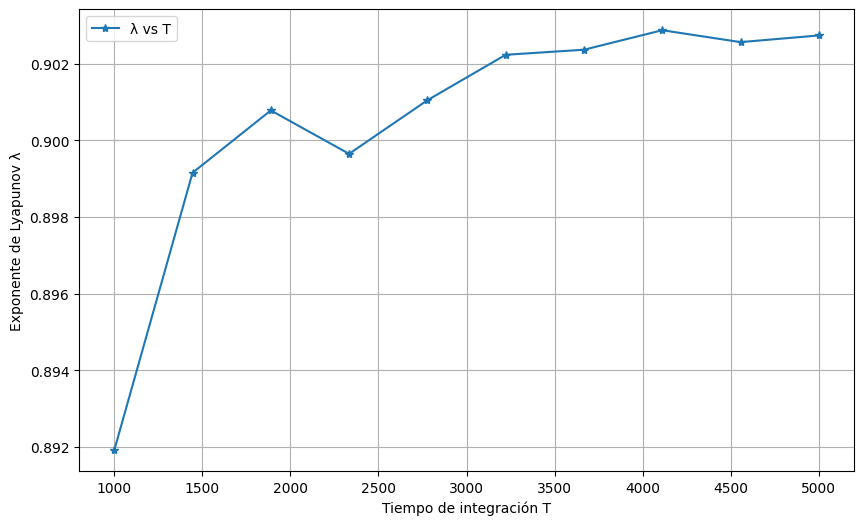

In [13]:
print("Exponente de Lyapunov λ:", lambda_max[-1])
plt.figure(figsize=(10, 6))
plt.plot(t_final, lambda_max, marker='*', label='λ vs T')
plt.xlabel('Tiempo de integración T')
plt.ylabel('Exponente de Lyapunov λ')
plt.grid(True)
plt.legend()
plt.show()

Como observamos en el gráfico, a medida que aumentamos los pasos, el coeficiente de Lyapunov se empieza a estabilizar y tiende hacia 0.906 que es el coeficiente teórico para los valores $\sigma= 10$, $\rho=28$ y $\beta = 8/3$.

Este no es el único exponente que hay dentro del sistema, ya que, jugando con los valores de estos tres parámetros mencionados, podemos obtener dos coeficientes más:
 - $\lambda _1$ = 0.906 (el que hemos obtenido: divergencia exponencial)
 - $\lambda _2$ = 0 (cuando el atractor sufre una dirección neutra)
 - $\lambda _3$ =  -14.572 (cuando el atractor sufre una contracción fuerte)

Para observar la convergencia de la serie podemos plotear $\lambda$ vs $\frac{1}{T}$ y ver, que, efectivamente y como se esperaba, sucede la convergencia al coeficiente 0.906.

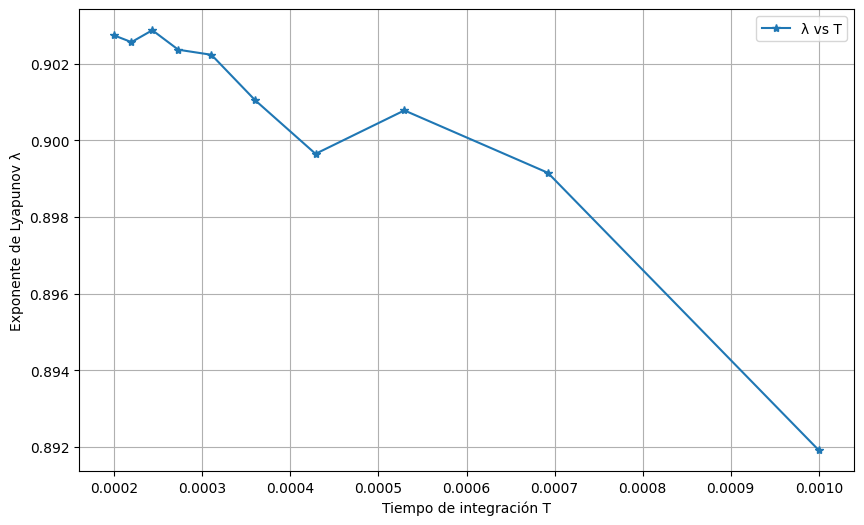

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(1/t_final, lambda_max, marker='*', label='λ vs T')
plt.xlabel('Tiempo de integración T')
plt.ylabel('Exponente de Lyapunov λ')
plt.grid(True)
plt.legend()
plt.show()

**Tips**
Si lleva mucho el tiempo de ejecución del programa, sobre todo la parte del cálculo, hago aqui unos pequeños tips que ate ayudaran a ver que parámetro reducir o aumentar según la necesidad:

- t_final ---> Aumenta el número de pasos de integración.
- h (paso)---> Disminuirlo aumenta precisión pero también coste.
- num_trials ---> Mejora estabilidad estadística, pero multiplica el tiempo.
- renorm_interval ---> Afecta frecuencia de reescalado, pero no tanto el coste total.